In [379]:
# import zhinst.ziPython, zhinst.utils
import zhinst.utils
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>")) #view options

In [380]:
device_id = 'dev1021'

In [381]:
# The API level supported by this example. Note, the HF2 data server
# only supports API Level 1.
apilevel = 1 
# Call a zhinst utility function that returns:
# - an API session `daq` in order to communicate with devices via the data server.
# - the device ID string that specifies the device branch in the server's node hierarchy.
# - the device's discovery properties.
err_msg = "This example only supports HF2 Instruments."
(daq, device, props) = zhinst.utils.create_api_session(device_id, apilevel, required_devtype='HF2',
                                                       required_err_msg=err_msg)
zhinst.utils.api_server_version_check(daq)

# Enable the API's log.
daq.setDebugLevel(3) #0 is most verbose; trace:0, info:1, debug:2, warning:3, error:4, fatal:5, status:6

zhinst.utils.api_server_version_check(daq)

# Create a base configuration: Disable all available outputs, awgs, demods, scopes,...
zhinst.utils.disable_everything(daq, device)



Discovered device `dev1021`: HF2LI with options MFK, PLL, PID, WEB.
Creating an API session for device `dev1021` on `127.0.0.1`, `8005` with apilevel `1`.


C:\Users\lab\Anaconda3\lib\site-packages\zhinst\utils.py:168: UserWarning: There is a mismatch between the versions of the API and Data Server. The API reports version `19.05' (revision: 65305) whilst the Data Server has version `18.05' (revision 54618). See the ``Compatibility'' Section in the LabOne Programming Manual for more information.
  warnings.warn(message)


[['/dev1021/dios/*/drive', 0],
 ['/dev1021/demods/*/enable', 0],
 ['/dev1021/demods/*/trigger', 0],
 ['/dev1021/demods/*/sinc', 0],
 ['/dev1021/demods/*/oscselect', 0],
 ['/dev1021/demods/*/harmonic', 1],
 ['/dev1021/demods/*/phaseshift', 0],
 ['/dev1021/pids/*/enable', 0],
 ['/dev1021/plls/*/enable', 0],
 ['/dev1021/sigins/*/ac', 0],
 ['/dev1021/sigins/*/imp50', 0],
 ['/dev1021/sigins/*/diff', 0],
 ['/dev1021/sigouts/*/on', 0],
 ['/dev1021/sigouts/*/enables/*', 0],
 ['/dev1021/sigouts/*/offset', 0.0],
 ['/dev1021/sigouts/*/add', 0],
 ['/dev1021/scopes/*/enable', 0]]

In [248]:
# Now configure the instrument for this experiment.


##  Signal Generation

In [4]:
S = settings = dict(
    dev='dev1021',
    out_chan = 0,
    out_demod = 6,
    out_freq = 3e6,
    out_range = 1.0, # V 
    out_amplitude = 0.5,
    out_offset = 0.5,
)

In [10]:
daq.set([('/{dev}/oscs/{out_chan}/freq'.format(**S), S['out_freq']),  #set frequency to 2.5 MHz
    ('/{dev}/sigouts/{out_chan}/range'.format(**S), S['out_range']), #set output range to 1 V
    #set output amplitude for demodulator 7 (zero indexed here but not on panel) to 0.5 V
    ('/{dev}/sigouts/{out_chan}/amplitudes/{out_demod}'.format(**S), S['out_amplitude']),
    ('/{dev}/sigouts/{out_chan}/enables/{out_demod}'.format(**S), True), #enable demodulator 7 output
    ('/{dev}/sigouts/{out_chan}/offset'.format(**S), S['out_offset']), #set overall output offset to 0.5 V
    ('/{dev}/sigouts/{out_chan}/on'.format(**S), True)]) #turn on output                                                    

In [11]:
daq.get('/dev1021/oscs/0/freq')

{'dev1021': {'oscs': {'0': {'freq': array([3000000.00000036])}}}}

#  Signal Input

In [382]:
settings.update(dict(
    in_chan = 0, #working with input channel 1 (of 6)
    in_range = 1.5, #volts, photodetector likely will exceed 1.5
#     in_AC_coupling = True, #input AC coupling on
#     in_imp_50 = True, #input impedence 50 ohm (alternative is "high") 
    in_AC_coupling = False, #input AC coupling on
    in_imp_50 = False, #input impedence 50 ohm (alternative is "high") 
    in_differential =  False, #input is absolute, not difference between + and - ports
    in_osc = 0, #use oscillator 1 for lock-in input
    input_signal = 0, #input is coming to "Input 1" on the front panel
    filter_order = 3,
    time_constant = 0.03, #time constant for signal filter [s]. 30 ms gives ~3.6 Hz 3 db BW
    data_trans_rate = 100 #Hz, arbitrary. High enough to not miss data, low enough to not saturate connection
    ))

daq.set([
    ('/{dev}/sigins/{in_chan}/range'.format(**S), S['in_range']), #input range: 1.5 V #the photodetector can definitely exceed this
    #instead of manually setting range, zhinst.utils.sigin_autorange(daq, device, in_chan) might be easier
    ('/{dev}/sigins/{in_chan}/ac'.format(**S), S['in_AC_coupling']), #input AC coupling on
    ('/{dev}/sigins/{in_chan}/imp50'.format(**S), S['in_imp_50']), #input 50 ohm impedence on (alternative is "high" impedance)
    ('/{dev}/sigins/{in_chan}/diff'.format(**S), False), #differential input mode off
    ('/{dev}/demods/{in_chan}/oscselect'.format(**S), S['in_osc']), #select oscillator 1 (zero indexing) for demodulator 1
    ('/{dev}/demods/{in_chan}/harmonic'.format(**S), 1), #use the first harmonic of oscillator 1
    ('/{dev}/demods/{in_chan}/adcselect'.format(**S), S['input_signal']), #for demod 1 use input signal 1 (zero indexing for both)
    ('/{dev}/demods/{in_chan}/order'.format(**S), S['filter_order']), #second order low-pass filter
    ('/{dev}/demods/{in_chan}/timeconstant'.format(**S), S['time_constant']), #30 ms time constant, ~3.6 Hz 3 db BW
    ('/{dev}/demods/{in_chan}/rate'.format(**S), S['data_trans_rate']), #data transfer rate 100 Hz #100 arbitrary, should be fine for 30 ms TC but possibly should change if TC decreased
    ('/{dev}/demods/{in_chan}/enable'.format(**S), True)]) #enable the demodulator

#alternate approach: could use zhinst.utils.save_settings(daq, device, filename) once 
#  and then zhinst.utils.save_settings(daq, device, filename) to load all at once

In [383]:
def get_enabled_vals():
    sigout_demod_str = '/{dev}/sigouts/{out_chan}/enables/{out_demod}'.format(**S)
    sigout_str = '/{dev}/sigouts/{out_chan}/on'.format(**S)
    sigin_demod_str = '/{dev}/demods/{in_chan}/enable'.format(**S)
    
    enabled_dict = dict()
    
    if daq.get(sigout_demod_str, True)[sigout_demod_str][0] == 1: 
        print('Output demodulator currently enabled.')
        enabled_dict['sigout_demod'] = True
    else: 
        print('Output demodulator currently disabled.')
        enabled_dict['sigout_demod'] = False
        
    if daq.get(sigout_str, True)[sigout_str][0] == 1: 
        print('Output demodulator currently enabled.')
        enabled_dict['sigout'] = True
    else: 
        print('Output demodulator currently disabled.')
        enabled_dict['sigout'] = False
        
    if daq.get(sigin_demod_str, True)[sigin_demod_str][0] == 1: 
        print('Output demodulator currently enabled.')
        enabled_dict['sigin_demod'] = True
    else: 
        print('Output demodulator currently disabled.')
        enabled_dict['sigin_demod'] = False
        
    return enabled_dict

get_enabled_vals()

Output demodulator currently disabled.
Output demodulator currently disabled.
Output demodulator currently enabled.


{'sigout_demod': False, 'sigout': False, 'sigin_demod': True}

In [8]:
#S

# Data acquisition: continuous

Subscribing to /dev1021/demods/0/sample.x
Subscribing to /dev1021/demods/0/sample.y
Subscribing to /dev1021/demods/0/sample.auxin0
Output demodulator currently enabled.
Output demodulator currently enabled.
Output demodulator currently enabled.


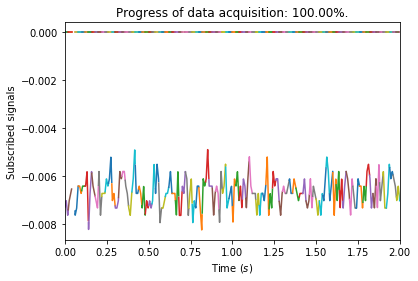

In [172]:
#working from example_data_acquisition_continuous.py
demod_path = '/{dev}/demods/{in_chan}/sample'.format(**S)
signal_paths = []
signal_paths.append(demod_path + '.x')  # The demodulator X output.
signal_paths.append(demod_path + '.y')  # The demodulator Y output.
signal_paths.append(demod_path + '.auxin0')  # The demodulator Y output.
# signal_paths.append('/{dev}/demods/{chan}/sample.r'.format(**S)) #general format


#seems like this is likely unnecessary since we know what device we have
# Check the device has demodulators.
flags = zhinst.ziPython.ziListEnum.recursive | zhinst.ziPython.ziListEnum.absolute | zhinst.ziPython.ziListEnum.streamingonly
streaming_nodes = daq.listNodes('/{}'.format(device), flags)
if demod_path.upper() not in streaming_nodes:
    print("Device {} does not have demodulators. Please modify the example to specify ".format(S['dev']),
          "a valid signal_path based on one or more of the following streaming nodes: ",
          "{}".format('\n'.join(streaming_nodes)))
    raise Exception("Demodulator streaming nodes unavailable - see the message above for more information.")

# Defined the total time we would like to record data for and its sampling rate.
# total_duration: Time in seconds: This examples stores all the acquired data in the `data` dict - remove this
# continuous storing in read_data_update_plot before increasing the size of total_duration!
total_duration = 2 #second
module_sampling_rate = 3000  # Number of points/second
burst_duration = 0.02  # Time in seconds for each data burst/segment.
num_cols = int(np.ceil(module_sampling_rate*burst_duration))
num_bursts = int(np.ceil(total_duration/burst_duration))

# Create an instance of the Data Acquisition Module.
h = daq.dataAcquisitionModule()

# Configure the Data Acquisition Module.

#set the device that will be used for the trigger - this parameter must be set
h.set("dataAcquisitionModule/device", S['dev']) 

#Specify continuous acquisition (type=0). other values refer to triggered inputs
h.set("dataAcquisitionModule/type", 0) 

# 'dataAcquisitionModule/grid/mode' - Specify the interpolation method of
#   the returned data samples.
# 1 = Nearest. If the interval between samples on the grid does not match
#     the interval between samples sent from the device exactly, the nearest
#     sample (in time) is taken.
# 2 = Linear interpolation. If the interval between samples on the grid does
#     not match the interval between samples sent from the device exactly,
#     linear interpolation is performed between the two neighbouring
#     samples.
# 4 = Exact. The subscribed signal with the highest sampling rate (as sent
#     from the device) defines the interval between samples on the DAQ
#     Module's grid. If multiple signals are subscribed, these are
#     interpolated onto the grid (defined by the signal with the highest
#     rate, "highest_rate"). In this mode, dataAcquisitionModule/duration is
#     read-only and is defined as num_cols/highest_rate.
# Using mode = 4 causes confusing timing problems
h.set("dataAcquisitionModule/grid/mode", 2) 

# 'dataAcquisitionModule/count' - Specify the number of bursts of data the
#   module should return (if dataAcquisitionModule/endless=0). The
#   total duration of data returned by the module will be
#   dataAcquisitionModule/count*dataAcquisitionModule/duration.
h.set("dataAcquisitionModule/count", num_bursts)

# 'dataAcquisitionModule/duration' - Burst duration in seconds.
#   If the data is interpolated linearly or using nearest neighbout, specify
#   the duration of each burst of data that is returned by the DAQ Module.
h.set("dataAcquisitionModule/duration", burst_duration) 

# 'dataAcquisitionModule/grid/cols' - The number of points within each duration.
#   This parameter specifies the number of points to return within each
#   burst (dataAcquisitionModule/duration seconds worth of data) that is
#   returned by the DAQ Module.
h.set("dataAcquisitionModule/grid/cols", num_cols)

data = dict()

for signal_path in signal_paths:
    print("Subscribing to", signal_path)
    h.subscribe(signal_path)
    data[signal_path] = []
   
    
do_plot = True 
clockbase = daq.getInt("/{}/clockbase".format(device)) #used to convert timestamps to seconds
if do_plot:
    fig = plt.figure(1)
    fig.clf()
    plt.xlabel('Time ($s$)')
    plt.ylabel('Subscribed signals')
    plt.xlim([0, total_duration])
    plt.ion()
    
ts0 = np.nan
read_count = 0

def read_data_update_plot(data, timestamp0):
    """
    Read the acquired data out from the module and plot it. Raise an
    AssertionError if no data is returned.
    """
    data_read = h.read(True) #read what data has been acquired to this point. True returns a flat dict
    returned_signal_paths = [signal_path.lower() for signal_path in data_read.keys()] 
    #    makes sure all returned signal paths are lowercase
    progress = h.progress()[0] #returns current progress of measurement as a fraction between 0 and 1
    # Loop over all the subscribed signals:
    for signal_path in signal_paths:
        if signal_path.lower() in returned_signal_paths:
            # Loop over all the bursts for the subscribed signal. More than
            # one burst may be returned at a time, in particular if we call
            # read() less frequently than the burst_duration.
            for index, signal_burst in enumerate(data_read[signal_path.lower()]):
                if np.any(np.isnan(timestamp0)):
                    # Set our first timestamp to the first timestamp we obtain.
                    timestamp0 = signal_burst['timestamp'][0, 0]
                # Convert from device ticks to time in seconds.
                t = (signal_burst['timestamp'][0, :] - timestamp0)/clockbase
                value = signal_burst['value'][0, :]
                if do_plot:
                    plt.plot(t, value)
                num_samples = len(signal_burst['value'][0, :])
                dt = (signal_burst['timestamp'][0, -1] - signal_burst['timestamp'][0, 0])/clockbase
                data[signal_path].append(signal_burst)
                do_print = False
                if do_print:
                    print("Read: ", read_count, ", progress: {0:.2f}%".format(100*progress), ". Burst ", index, ": ",
                          signal_path, " contains ", num_samples, " spanning {0:.2f} s.".format(dt), sep="")
        else:
            # Note: If we read before the next burst has finished, there may be no new data.
            # No action required.
            pass

    # Update the plot.
    if do_plot:
        plt.title("Progress of data acquisition: {0:.2f}%.".format(100*progress))
#         plt.pause(0.01) #doesn't play nice with Jupyter
        fig.canvas.draw()
    return data, timestamp0

# Record data in a loop with timeout.
timeout = 5*total_duration
# timeout = 1.5*total_duration
t0_measurement = time.time()
# The maximum time to wait before reading out new data.
t_update = 0.9*burst_duration
# t_update = 0.9*burst_duration

status = get_enabled_vals()
if status['sigin_demod'] == False:
    raise Exception("Input demodulator disabled. No data to measure.")

# Start recording data.
h.execute()

while not h.finished():
    t0_loop = time.time()
    if time.time() - t0_measurement > timeout:
        raise Exception("Timeout after {} s - recording not complete. Are the streaming nodes enabled? "
                        "Has a valid signal_path been specified?".format(timeout))
    data, ts0 = read_data_update_plot(data, ts0)
    read_count += 1
    # We don't need to update too quickly.
    time.sleep(max(0, t_update - (time.time() - t0_loop)))
      
    
h.finish()
h.unsubscribe('*')

# There may be new data between the last read() and calling finished().
data, _ = read_data_update_plot(data, ts0)

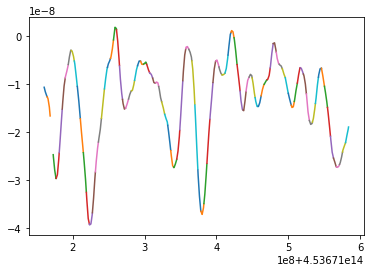

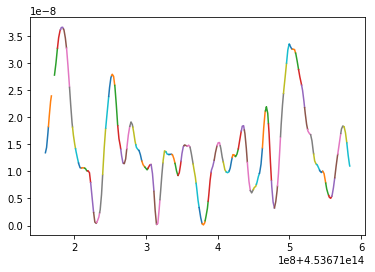

In [173]:
for burst in data[signal_paths[0]]:
#     print(burst['timestamp'])
    plt.plot(burst['timestamp'].flatten(),burst['value'].flatten())
#     print(len(burst['value'][0]))
plt.figure()
for burst in data[signal_paths[1]]:
    plt.plot(burst['timestamp'].flatten(),burst['value'].flatten())

In [174]:
status = get_enabled_vals()
if status['sigin_demod'] == False:
    raise Exception("Input demodulator disabled. No data to measure.")

h.execute()
while not h.finished():
    time.sleep(0.1)
data = dict()
for signal_path in signal_paths:
    data[signal_path] = []
ts0 = np.nan
data = read_data_update_plot(data, ts0)

Output demodulator currently enabled.
Output demodulator currently enabled.
Output demodulator currently enabled.


# Data acquisition: once

poll() returned 0.089 seconds of demodulator data.
Average measured RMS amplitude is 1.288e-07 V.


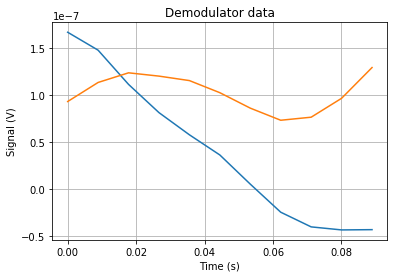

In [25]:
#working from example_poll.py


# Unsubscribe any streaming data.
daq.unsubscribe('*')

# Wait for the demodulator filter to settle.
time.sleep(10*S['time_constant'])

# Perform a global synchronisation between the device and the data server:
# Ensure that 1. the settings have taken effect on the device before issuing
# the poll() command and 2. clear the API's data buffers. Note: the sync()
# must be issued after waiting for the demodulator filter to settle above.
daq.sync()

# Subscribe to the demodulator's sample node path.
demod_path = '/{dev}/demods/{in_chan}/sample'.format(**S)
daq.subscribe(demod_path)

# # Sleep for demonstration purposes: Allow data to accuSmulate in the data
# # server's buffers for one second: poll() will not only return the data
# # accumulated during the specified poll_length, but also for data
# # accumulated since the subscribe() or the previous poll.
sleep_length = 1.0
# # For demonstration only: We could, for example, be processing the data
# # returned from a previous poll().
# time.sleep(sleep_length)

# Poll the subscribed data from the data server. Poll will block and record
# for poll_length seconds.
poll_length = 0.1  # [s]
poll_timeout = 500  # [ms]
poll_flags = 0
poll_return_flat_dict = True
data = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)

# Unsubscribe from all paths.
daq.unsubscribe('*')

# Check the dictionary returned is non-empty
assert data, "poll() returned an empty data dictionary, did you subscribe to any paths?"

# The data returned is a dictionary of dictionaries that reflects the node's path.
# Note, the data could be empty if no data had arrived, e.g., if the demods
# were disabled or had demodulator rate 0.
assert demod_path in data, "The data dictionary returned by poll has no key `%s`." % demod_path

# Access the demodulator sample using the node's path.
sample = data[demod_path]

# Let's check how many seconds of demodulator data were returned by poll.
# First, get the sampling rate of the device's ADCs, the device clockbase...
clockbase = float(daq.getInt('/%s/clockbase' % S['dev']))
# ... and use it to convert sample timestamp ticks to seconds:
dt_seconds = (sample['timestamp'][-1] - sample['timestamp'][0])/clockbase
print("poll() returned {:.3f} seconds of demodulator data.".format(dt_seconds))
tol_percent = 10
dt_seconds_expected = sleep_length + poll_length
assert (dt_seconds - dt_seconds_expected)/dt_seconds_expected*100 < tol_percent, \
    "Duration of demod data returned by poll() (%.3f s) differs " % dt_seconds + \
    "from the expected duration (%.3f s) by more than %0.2f %%." % \
    (dt_seconds_expected, tol_percent)

# Calculate the demodulator's magnitude and phase and add them to the dict.
sample['R'] = np.abs(sample['x'] + 1j*sample['y'])
sample['phi'] = np.angle(sample['x'] + 1j*sample['y'])
print("Average measured RMS amplitude is {:.3e} V.".format(np.mean(sample['R'])))

do_plot = True
if do_plot:
#     import matplotlib.pyplot as plt

    # Convert timestamps from ticks to seconds via clockbase.
    t = (sample['timestamp'] - sample['timestamp'][0])/clockbase

    # Create plot
    plt.figure()
    plt.grid(True)
    plt.plot(t, sample['x'])
    plt.plot(t, sample['y'])
    plt.title('Demodulator data')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal (V)')
    mean_r = np.mean(sample['R'])
#     plt.axis([t[0], t[-1], 0.99*mean_r, 1.01*mean_r])
    plt.draw()
    plt.show()
    
# print(sample.keys())

# One-shot raw data by querying scope node

In [336]:
#testing scopes/0/wave

daq.setInt('/dev1021/scopes/0/enable',1)

# Unsubscribe any streaming data.
daq.unsubscribe('*')

# Wait for the demodulator filter to settle.
time.sleep(10*S['time_constant'])

# Perform a global synchronisation between the device and the data server:
# Ensure that 1. the settings have taken effect on the device before issuing
# the poll() command and 2. clear the API's data buffers. Note: the sync()
# must be issued after waiting for the demodulator filter to settle above.
daq.sync()

# # Subscribe to the demodulator's sample node path.
scope_path = '/{dev}/scopes/0/wave'.format(**S)
# # demod_path = '/{dev}/demods/{in_chan}/sample'.format(**S)
# daq.subscribe(scope_path)
daq.subscribe('/dev1021/scopes/0/wave')

# # Sleep for demonstration purposes: Allow data to accuSmulate in the data
# # server's buffers for one second: poll() will not only return the data
# # accumulated during the specified poll_length, but also for data
# # accumulated since the subscribe() or the previous poll.
sleep_length = 0.5
# # For demonstration only: We could, for example, be processing the data
# # returned from a previous poll().
# time.sleep(sleep_length)

# Poll the subscribed data from the data server. Poll will block and record
# for poll_length seconds.
poll_length = 0.01  # [s]
poll_timeout = 500  # [ms]
poll_flags = 0
poll_return_flat_dict = True
data = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)

scaling = daq.getDouble('/{dev}/sigins/{in_chan}/range'.format(**S))
# print(scaling)

# Unsubscribe from all paths.
daq.unsubscribe('*')

# Check the dictionary returned is non-empty
assert data, "poll() returned an empty data dictionary, did you subscribe to any paths?"

# The data returned is a dictionary of dictionaries that reflects the node's path.
# Note, the data could be empty if no data had arrived, e.g., if the demods
# were disabled or had demodulator rate 0.
assert scope_path in data, "The data dictionary returned by poll has no key `%s`." % demod_path

# Access the demodulator sample using the node's path.
sample = data[scope_path]

# # Let's check how many seconds of demodulator data were returned by poll.
# # First, get the sampling rate of the device's ADCs, the device clockbase...
# clockbase = float(daq.getInt('/%s/clockbase' % S['dev']))
# # ... and use it to convert sample timestamp ticks to seconds:
# dt_seconds = (sample['timestamp'][-1] - sample['timestamp'][0])/clockbase
# print("poll() returned {:.3f} seconds of demodulator data.".format(dt_seconds))
# tol_percent = 10
# dt_seconds_expected = sleep_length + poll_length
# assert (dt_seconds - dt_seconds_expected)/dt_seconds_expected*100 < tol_percent, \
#     "Duration of demod data returned by poll() (%.3f s) differs " % dt_seconds + \
#     "from the expected duration (%.3f s) by more than %0.2f %%." % \
#     (dt_seconds_expected, tol_percent)

for entry in sample:
    print(scaling)
#     print(entry['wave'])
    data_corrected = entry['wave']*scaling/2**15 #8192 is range of ADC
    plt.plot(data_corrected)
    
    #correction factor of 2**15 seems plausible but I'm not certain

0.10203302143024649


# Data acquisition: continuous raw data with scopeModule

In [390]:
h = daq.scopeModule()

h.subscribe('/dev1021/scopes/0/wave')

all_data = []

# h.execute()
# daq.setInt('/dev1021/scopes/0/channel',0) #0 = Signal Input 1
# daq.setInt('/dev1021/scopes/0/enable', 1)
daq.set([('/dev1021/scopes/0/channel',0)]) #0 = Signal Input 1
daq.setInt('/dev1021/scopes/0/enable', True)



#set "external scaling" to the value of the corresponding device RANGE node
ext_scale = daq.getDouble('/dev1021/sigins/0/range')
# print(h.get('/scopeModule/externalscaling'))
h.set('/scopeModule/externalscaling', ext_scale)
print(ext_scale)

h.set("scopeModule/mode", 1) #1 is time domain and 3 is freq. 0 is 'pass-through', no processing; 2 does not exist

h.set("scopeModule/averager/weight", 1) #no averaging

num_records = 15
h.set("scopeModule/historylength",num_records)
# h.set("scopeModule/samplecount",1) #not a valid property


h.execute()
# print(daq.getInt('/dev1021/scopes/0/segments/enable'))

start_time = time.time()
timeout = 3

# while h.progress()<1:
#     print(h.progress())
#     time.sleep(1)

while h.progress()<1 and (time.time()-start_time)<timeout: #h.finished() never true
    data_read = h.read(True)
#     print(data_read)
    if '/dev1021/scopes/0/wave' in data_read:
#         for key in data_read:
#             print(key)
#         print("---")
#         print(data_read['/records'])
        all_data.append(data_read)
#         print(h.progress())
data_read = h.read(True)
if '/dev1021/scopes/0/wave' in data_read:
#     for key in data_read:
#         print(key)
#     print("---")
#     print(data_read['/records'])
    all_data.append(data_read)
    
daq.setInt('/dev1021/scopes/0/enable', 0)    
h.finish()
h.unsubscribe('*')



1.5198682827977321


In [391]:
for entry in all_data:
    if '/dev1021/scopes/0/wave' in entry:
#         print('new entry-------')
#         for key in entry:
#             print(key)
#             print(entry[key])

        if '/error' in entry:
            if entry['/error'][0]:
                break
        wave_entry = entry['/dev1021/scopes/0/wave'][0][0]
#         print(wave_entry['wave'][0])
#         for key in wave_entry:
#             print(key)
#             print(wave_entry[key])
#             print("")
        print(wave_entry['flags'])
        wave = wave_entry['wave'][0]
        scaling = -1
        for i in range(len(wave_entry['channelenable'])):
            if wave_entry['channelenable'][i]:
                if scaling == -1:
                    scaling = wave_entry['channelscaling'][i]
#                     print(scaling)
                else:
                    print('warning: multiple scalings found')
        plt.plot(wave/scaling)
    else: 
        print("what?")
        print(entry)
        
# #         print(entry['/dev1021/scopes/0/wave'][0][0]['channelscaling'])
#         print(entry['/dev1021/scopes/0/wave'][0][0]['channelenable'])
#         print(entry['/dev1021/scopes/0/wave'][0][0]['wave'])
#         print (entry['/dev1021/scopes/0/wave'][0][0])
print(np.mean(data_corrected)/np.mean(wave))#2**15 gave reasonable values
print(np.std(data_corrected)/np.mean(data_corrected))


8
-0.044805613418151806
-0.24831076555347226


In [349]:
print(daq.getDouble('/dev1021/status/adc0min'),daq.getDouble('/dev1021/status/adc0max'))
np.max([np.abs(daq.getDouble('/dev1021/status/adc0max')), np.abs(daq.getDouble('/dev1021/status/adc0min'))])/8192.

-23.0 9.0


0.0028076171875

In [288]:
# print(sample.keys())
# # print(sample['time']['dataloss'])
# print(sample['phi'])

daq.getSample()

ArgumentError: Python argument types in
    None.getSample(ziDAQServer)
did not match C++ signature:
    getSample(class zhinst::pyDAQServer {lvalue} self, class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > path)

# Frequency sweep

Subscribing to /dev1021/demods/0/sample
Output demodulator currently enabled.
Output demodulator currently enabled.
Output demodulator currently enabled.
Progress: 2.00% Time remining: 1.52 seconds
Progress: 44.00% Time remining: 0.87 seconds
Progress: 86.00% Time remining: 0.22 seconds
Progress: 100.00% Time remining: 0.00 seconds


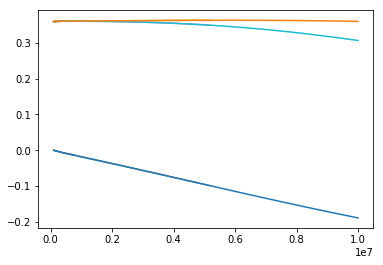

In [221]:
#playing with trying to set up frequency sweeping
sweep_params = dict(
    start_freq = 0.1e6, #Hz
    stop_freq = 10e6, #MHz
    samples = 50, #number of data points   
    averaging_tc = 15, # min averaging time, 0 for none, [5, 15, 50] recommended for [low, med, high] precision
    # use one of averaging_tc or averaging_sample or averaging_time
#     averaging_sample = 1, #min number of sample points to average
    settling_inaccuracy = 1e-4, 
    # filter setting--will wait long enough to reach this remaining proportion of an incoming step function
    bandwidth_control = 2, #0 = manual, 1 = fixed, 2 = auto. 2 default
    max_bandwidth = 1.25e6, #maximum bandwidth used in auto bandwidth mode, 1.25 MHz default
    omega_suppresion = 40, #damping (dB) for omega and 2-omega components. 40 is default
    history_length = 100, #upper limit for number of captures stored in the module
    save_directory = "C:\\Users\\lab\\Documents\\foundry_scope\\TDTR\\test_recordings\\", #base directory for saving files
    save_filename = 'test', #subdirectory for saving files
    file_format = 1, #format of saved files: 0 = Matlab, 1 = csv
    to_save = False, #flag for whether to save this sweep
    loop_count = 1, #number of scans to complete
    endless = False, #False to excecute loop_count times, True to run indefinitely
)

h2 = daq.sweep()
h2.set("sweep/device", S['dev']) #device to use for parameter sweep
h2.set("sweep/historylength", sweep_params['history_length'])
h2.set("sweep/start", sweep_params['start_freq']) #set starting frequency
h2.set("sweep/stop", sweep_params['stop_freq']) #set ending frequency
h2.set("sweep/gridnode", 'oscs/{out_chan}/freq'.format(**S)) #set parameter to sweep: modulation freq
h2.set("sweep/samplecount", sweep_params['samples'])
h2.set("sweep/xmapping", 1) #logarithmic sweep, 0 for linear
h2.set("sweep/order", S['filter_order']) #set order for low-pass filter
h2.set("sweep/settling/inaccuracy", sweep_params['settling_inaccuracy'])
h2.set("sweep/averaging/tc", sweep_params['averaging_tc'])
h2.set("sweep/bandwidthcontrol", sweep_params['bandwidth_control'])
h2.set("sweep/maxbandwidth", sweep_params['max_bandwidth'])
h2.set("sweep/omegasuppression", sweep_params['omega_suppresion'])
h2.set("sweep/historylength", sweep_params['history_length'])
h2.set("sweep/save/directory", sweep_params['save_directory'])
h2.set("sweep/save/filename", sweep_params['save_filename'])
# h2.set("sweep/fileformat", sweep_params['file_format']) #gives an error saying fileformat is not a valid selection
h2.set("sweep/save/save", sweep_params['to_save'])
h2.set("sweep/loopcount", sweep_params['loop_count'])
h2.set("sweep/endless", sweep_params['endless'])


demod_path = '/{dev}/demods/{in_chan}/sample'.format(**S)

print("Subscribing to", demod_path)
h2.subscribe(demod_path)
# h2.subscribe(demod_path+'.x')

signals = ['x', 'y', 'r']

data = dict()
data['frequency'] = []
for signal in signals:
    data[signal] = []

def read_sweep(data, timestamp0, do_plot = True):
    """
    Read the acquired data out from the sweep module.
    """
    data_read = h2.read(True) #read what data has been acquired to this point. True returns a flat dict
    
#     print(data_read.keys())
    
    time_left = data_read['/remainingtime'][0]
    
    if np.any(np.isnan(timestamp0)):
        # Set our first timestamp to the first timestamp we obtain.
        timestamp0 = data_read[demod_path][0][0]['timestamp']
    
    data['frequency'] = data_read[demod_path][0][0]['frequency']
    
    for signal in signals:
        if signal in data_read[demod_path][0][0].keys(): #desired signal was recorded
            data[signal] = data_read[demod_path][0][0][signal]

    do_print = True
    if do_print:
        print("Progress: {0:.2f}%".format(100*h2.progress()[0]), "Time remining: {0:.2f} seconds".format(time_left))
    
    if do_plot:
        for signal in signals:
            plt.plot(data['frequency'], data[signal])
            
    return data, timestamp0, time_left

timeout = 10
t0_measurement = time.time()
wait_time = 1

ts0 = np.nan

status = get_enabled_vals()
if status['sigin_demod'] == False:
    raise Exception("Input demodulator disabled. No data to measure.")

# Start recording data.
h2.execute()

h2.read(True) 
while h2.progress()[0] < 0.01:
    time.sleep(0.01)

# The data structure changes in the first few moments after the run starts.
# This seems to make it stable before we go on

while not h2.finished():
    t0_loop = time.time()
    if time.time() - t0_measurement > timeout:
        raise Exception("Timeout after {} s - recording not complete.".format(timeout))
    data, ts0, t_remain = read_sweep(data, ts0)
    time.sleep(wait_time)
if t_remain != 0: #exited the loop before all the data was recorded
    data, ts0, t_remain = read_sweep(data, ts0)
# if sweep_params['to_save']:
#     h2.save(sweep_params['save_directory']+sweep_params['save_filename'])
    
h2.finish()
h2.unsubscribe('*')

# data_read = h2.read(True)

In [213]:
data_read['/dev1021/demods/0/sample'][0][0].keys()

dict_keys(['header', 'timestamp', 'samplecount', 'flags', 'sampleformat', 'sweepmode', 'bandwidthmode', 'auxin0', 'auxin0pwr', 'auxin0stddev', 'auxin1', 'auxin1pwr', 'auxin1stddev', 'bandwidth', 'frequency', 'frequencypwr', 'frequencystddev', 'grid', 'phase', 'phasepwr', 'phasestddev', 'r', 'rpwr', 'rstddev', 'settling', 'tc', 'tcmeas', 'x', 'xpwr', 'xstddev', 'y', 'ypwr', 'ystddev', 'count', 'nexttimestamp', 'settimestamp'])

# disconnect

In [14]:
# daq.set([
#     ('/{dev}/sigouts/{out_chan}/enables/{out_demod}'.format(**S), False), #disable demodulator 7 output
#     ('/{dev}/sigouts/{out_chan}/on'.format(**S), False), #turn off output     
#     ('/{dev}/demods/{in_chan}/enable'.format(**S), True)]) #disable the demodulator

daq.unsubscribe('*')
zhinst.utils.disable_everything(daq, device)

[['/dev1021/dios/*/drive', 0],
 ['/dev1021/demods/*/enable', 0],
 ['/dev1021/demods/*/trigger', 0],
 ['/dev1021/demods/*/sinc', 0],
 ['/dev1021/demods/*/oscselect', 0],
 ['/dev1021/demods/*/harmonic', 1],
 ['/dev1021/demods/*/phaseshift', 0],
 ['/dev1021/pids/*/enable', 0],
 ['/dev1021/plls/*/enable', 0],
 ['/dev1021/sigins/*/ac', 0],
 ['/dev1021/sigins/*/imp50', 0],
 ['/dev1021/sigouts/*/on', 0],
 ['/dev1021/sigouts/*/enables/*', 0],
 ['/dev1021/sigouts/*/offset', 0.0],
 ['/dev1021/scopes/*/enable', 0]]

In [256]:
zhinst.__file__

'C:\\Users\\lab\\Anaconda3\\envs\\scopefoundry\\lib\\site-packages\\zhinst\\__init__.py'

# scratch

-0.10445508857877778 1.176104986033395


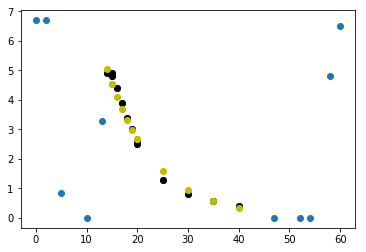

In [374]:
pos = np.array([60,58,54,52,47,40,35,30,25,20,15,10,5,2,0,18,17,16,15,14,13,19,20])
intensity = np.array([6.5,4.8,0,0,0,0.4,0.56,0.81,1.3,2.52,4.82,0,0.85,6.7,6.7,3.4,3.9,4.4,4.9,4.9,3.3,3.0,2.6])
plt.plot(pos, intensity, 'o')

pos_mask_min = pos>13
pos_mask_max = pos<45
pos_mask = np.array([all(tup) for tup in zip(pos_mask_min, pos_mask_max)])

pos_sel = pos[pos_mask]
intens_sel = intensity[pos_mask]

plt.plot(pos_sel, intens_sel, 'ko')

# log_intens = np.log(intens_sel/max(intensity))
# plt.figure()
# plt.plot(pos_sel, log_intens, 'o')

# coeffs = np.polyfit(pos_sel, log_intens, 1)
# print(coeffs)
# plt.plot(pos_sel, [coeffs[1]+coeffs[0]*pos for pos in pos_sel])

def predict_intens_frac(pos):
    return np.exp(coeffs[1]+coeffs[0]*pos)

plt.plot(pos_sel, [predict_intens_frac(x)*max(intensity) for x in pos_sel], 'yo')

print(coeffs[0], coeffs[1])

In [376]:
for pos in [14, 45]:
    print(np.exp(1.176104986033395-0.10445508857877778*pos))

0.7510626158447337
0.02947024997211093


In [378]:
ND_predict_coeff_0 = 1.176104986033395
ND_predict_coeff_1 = -0.10445508857877778
pos = 23
intens_frac = np.exp(ND_predict_coeff_0 + ND_predict_coeff_1*pos)
print((np.log(intens_frac) - ND_predict_coeff_0)/ND_predict_coeff_1)


23.0
